# INTRODUCTION

### The time series ananlysis carried out on Amazon stock price with the data gotten from Panda's yfinance library. ARIMA model as well as smoothing and decomposition were implemented.

In [69]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [70]:
# Fetch data.
# Interest is on the closing price column only.
data = yf.download('AMZN', start='2024-01-01', end='2024-07-01')
data = data[['Close']]  # Focus on the 'Close' price
data = data.asfreq('B')  # Business days frequency
data

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2024-01-02,149.929993
2024-01-03,148.470001
2024-01-04,144.570007
2024-01-05,145.240005
2024-01-08,149.100006
...,...
2024-06-24,185.570007
2024-06-25,186.339996
2024-06-26,193.610001


In [71]:
# Forward fill empty dates.
data = data.fillna(method='ffill')
data

C:\Users\USER\AppData\Local\Temp\ipykernel_372104\2074418932.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


,Close
Date,
2024-01-02,149.929993
2024-01-03,148.470001
2024-01-04,144.570007
2024-01-05,145.240005
2024-01-08,149.100006
...,...
2024-06-24,185.570007
2024-06-25,186.339996
2024-06-26,193.610001


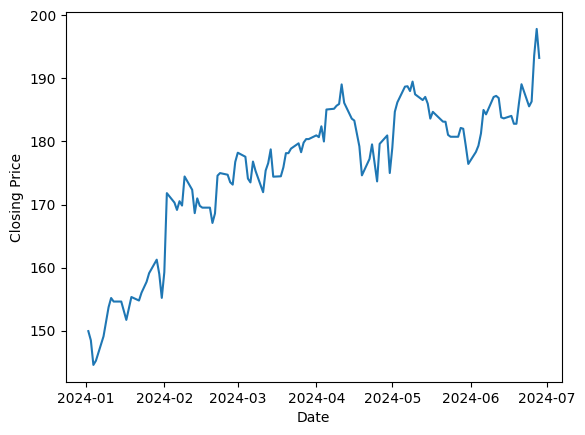

In [72]:
# Plot the dataset.
plt.xlabel('Date')
plt.ylabel("Closing Price")
plt.plot(data)
plt.show()

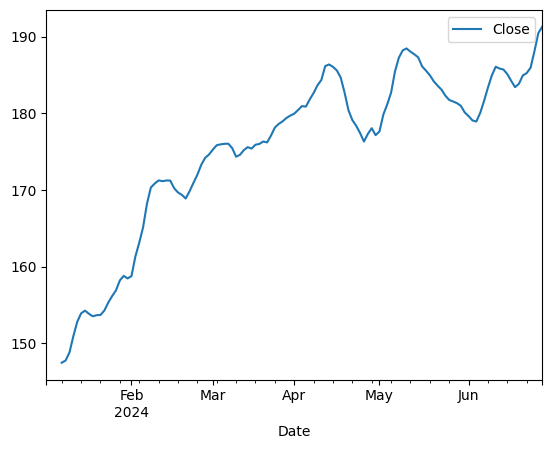

In [73]:
# Smoothing using a rolling mean
data_smoothed = data.rolling(window=5).mean()
data_smoothed.plot()
plt.show()

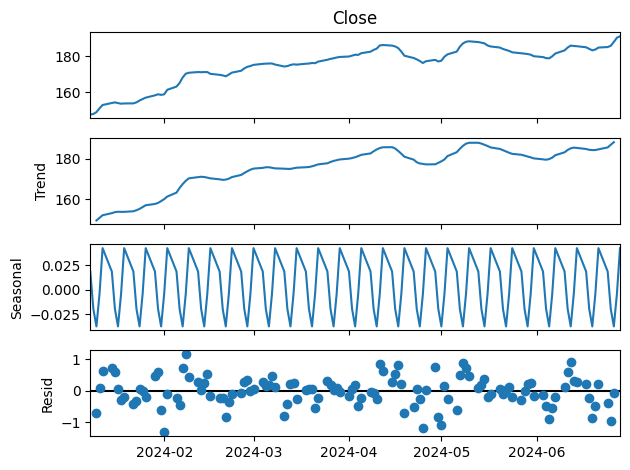

In [74]:
# Decompose the time series
decomposition = seasonal_decompose(data_smoothed['Close'].dropna(), model='additive')
decomposition.plot()
plt.show()


In [ ]:
# Drop empty entries.
data_smoothed_clean = data_smoothed.dropna()
data_smoothed_clean = data_smoothed.fillna(method='ffill')

In [81]:
data_smoothed_clean = data_smoothed.dropna()

In [82]:
print(len(data_smoothed_clean))

125


In [83]:
# Checking if the series is stationary or not.
print('Results of Dickey-Fuller Test:')
dftest = adfuller(data_smoothed_clean['Close'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistics                 -2.393747
p-value                          0.143509
#Lags Used                      11.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


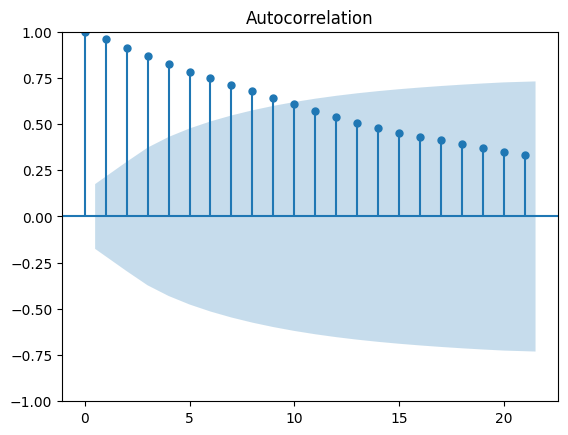

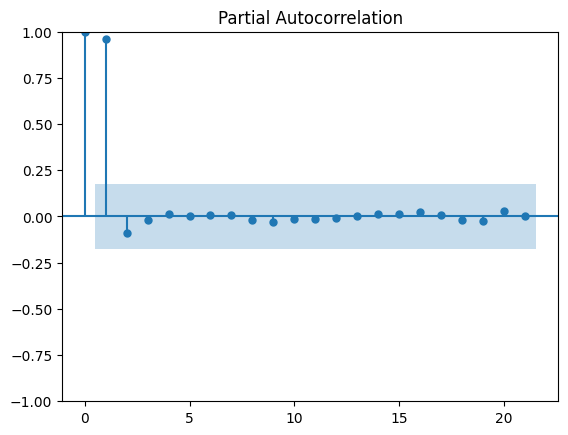

In [84]:
# Plot ACF and PACF
plot_acf(data_smoothed_clean)
plot_pacf(data_smoothed_clean)
plt.show()

In [85]:
# Fit ARIMA model (order should be determined from ACF/PACF)
model = ARIMA(data_smoothed_clean, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  125
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -124.861
Date:                Tue, 24 Sep 2024   AIC                            255.722
Time:                        17:32:35   BIC                            264.183
Sample:                    01-08-2024   HQIC                           259.159
                         - 06-28-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5756      0.095      6.035      0.000       0.389       0.762
ma.L1          0.4082      0.097      4.195      0.000       0.217       0.599
sigma2         0.4351      0.050      8.722      0.0

In [86]:
# Forecasting
forecast = model_fit.forecast(steps=2*22)  # Assuming ~22 trading days per month
forecast_index = pd.date_range(start='2024-07-01', periods=len(forecast), freq='B')
forecast_series = pd.Series(forecast, index=forecast_index)

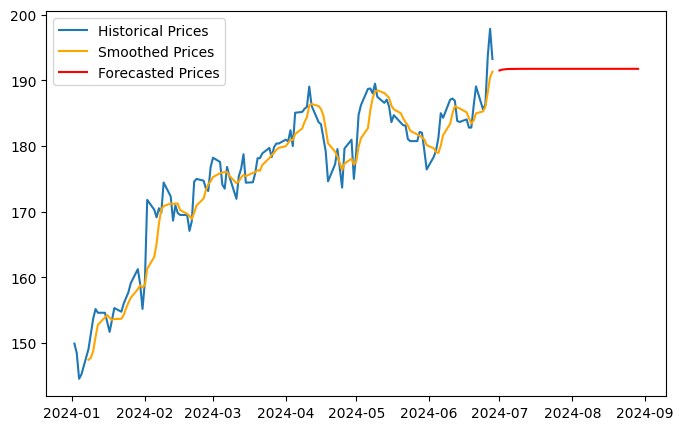

In [87]:
# Plotting the forecast
plt.figure(figsize=(8, 5))
plt.plot(data, label='Historical Prices')
plt.plot(data_smoothed_clean, label='Smoothed Prices', color='orange')
plt.plot(forecast_series, label='Forecasted Prices', color='red')
plt.legend()
plt.show()

In [88]:
# Fetch actual data for July and August 2024
actual_data = yf.download('AMZN', start='2024-07-01', end='2024-09-01')['Close'].asfreq('B')

[*********************100%%**********************]  1 of 1 completed


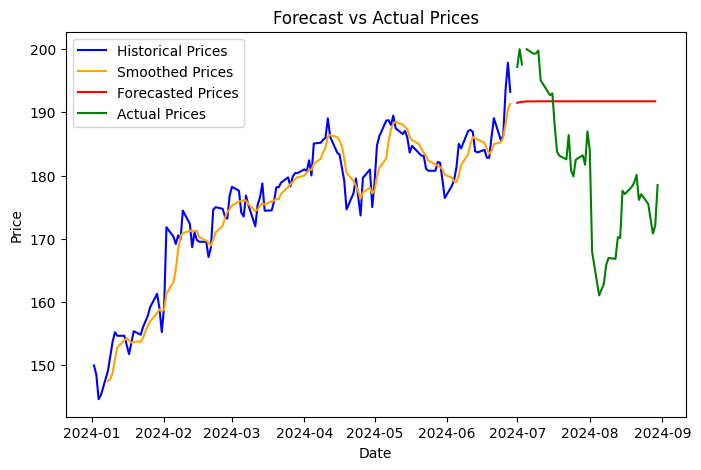

In [89]:
# Plotting the forecast against actual data
plt.figure(figsize=(8, 5))
plt.plot(data, label='Historical Prices', color='blue')
plt.plot(data_smoothed_clean, label='Smoothed Prices', color='orange')
plt.plot(forecast_series, label='Forecasted Prices', color='red')
plt.plot(actual_data, label='Actual Prices', color='green')
plt.title('Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [92]:
# Checking the accuraacy of the nodel.
mape = np.mean(np.abs(
    (actual_data[:len(forecast_series)] - forecast_series) / actual_data[:len(forecast_series)])) * 100

mse = np.mean((actual_data[:len(forecast_series)] - forecast_series) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actual_data[:len(forecast_series)] - forecast_series))


In [93]:
# Print the result.
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

MAPE: 7.50%
MSE: 236.31
RMSE: 15.37
MAE: 13.09


### Based on the analysis carried out, the following information were derived.

1.  An MAPE (Mean Absolute Percentage Error) of 7.50% suggests that on average, the forecasted value deviates from the actual values by about 7.50%. Generally, a MAPE below 10% is considered excellent in forecasting. This indicates that this model's predication is fairly accurate.

2.  An MAE (Mean Absolute Error) of 13.09 indicates that on average, this model's prodictions are off by about $13.09.